In [4]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import h5py
import yaml
import scipy.interpolate as interpolate
import pandas as pd
from scipy.stats import norm, chi2
from pathlib import Path
import uproot

# plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 15

One file with all data:

In [2]:
filename = "/data/magic/users-ifae/rgrau/EBL-splines/EBL_fit_MC_MBPWL_nit50_20220504102545.hdf5"

load = h5py.File(filename,"r")
chisqs_iter = np.array(load['chisqs'])
alphas_iter = np.array(load['alphas'])

with open("EBL_fit_config.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
niter = inp_config["niter"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        Elast = inp_config["Elast"]

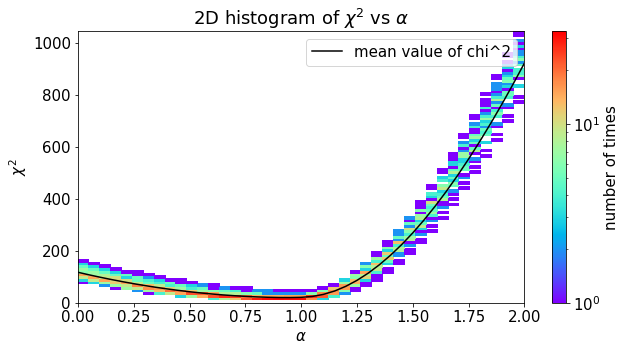

A 0.28 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 0.47 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 0.5 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The median minimum is at alpha =  0.9  +  0.07  -  0.06
Energy migration =  True


In [3]:
chisqs_iter = np.array(chisqs_iter)
alphas_iter = np.array(alphas_iter)
alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of chi^2 values")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.legend()
ax.set_ylim(bottom = 0)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\chi^2$ vs $\alpha$")
plt.show()

sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    number = np.where(np.round(alphas, decimals = 4) == 1)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / niter * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / niter * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / niter * 100, decimals = 3)))
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 3), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
print("Energy migration = ", Energy_migration)



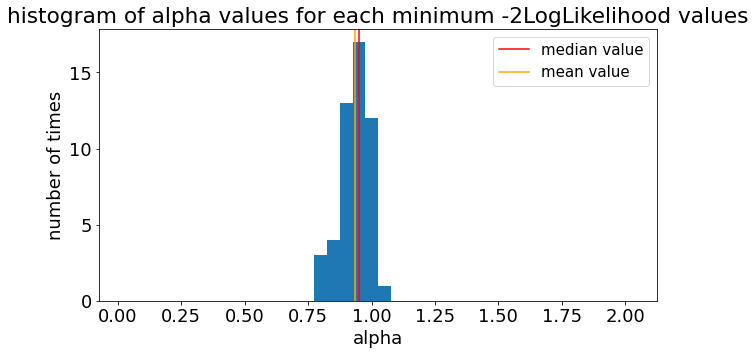

The mean is: 0.9340 ± 0.0006
Energy migration = True


In [4]:
mu, std = norm.fit(alphas[np.argmin(chisqs_iter, axis = 1)])

plt.hist(alphas[np.argmin(chisqs_iter, axis = 1)], np.sort(alphas)+0.025)
xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
p = norm.pdf(np.sort(alphas), mu, std)
plt.axvline(np.median(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "median value", color = "red")
plt.axvline(np.mean(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "mean value", color = "orange",)
#plt.plot(np.sort(alphas), p/p.sum() * niter, 'k', linewidth=2)
plt.xlabel("alpha")
plt.ylabel("number of times")
plt.title("histogram of alpha values for each minimum -2LogLikelihood values")
plt.legend(fontsize = 15)
plt.show()
print("The mean is:", format(mu, ".4f"), u"\u00B1", format(std/np.sqrt(niter), ".4f"))
print("Energy migration =", Energy_migration)

# Multiple files with data:

In [15]:
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas
locname = '/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_PWL_MAGIC_with_0.07_Systematics_4w_fix_2errors'
loc = Path(locname)

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)


# dffinal = pd.concat([extract(name) for name in files] )

# chisqs_iter = np.array(dffinal['chisqs'])
# alphas_iter = np.array(dffinal['alphas'])

with open(locname + "/EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        Elast = inp_config["Elast"]

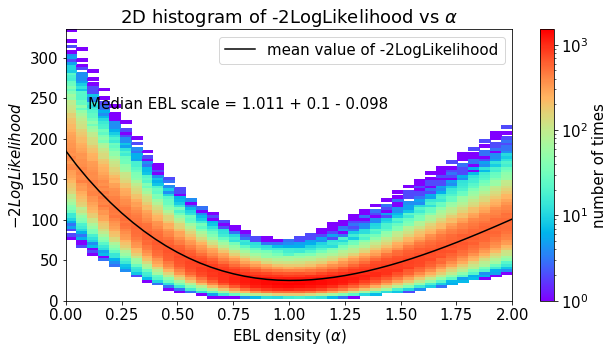

A 54.72 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 87.13 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 97.77 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
0 of 10000 itertions failed to converge
Δχ^2 min-0 = 159.88309768854893
Δχ^2 min-2 = 75.7655956109509


In [3]:
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

niter = len(chisqs_iter)

alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of -2LogLikelihood")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of -2LogLikelihood values")
#ax.plot(magicalphas, magichis, color = "grey", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.set_xlabel(r'EBL density ($\alpha$)')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend()
ax.set_ylim(bottom = 0)
# ax.axvline(x = 1)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of -2LogLikelihood vs $\alpha$")


interpx2 = np.arange(first_bin, last_bin, step/500)
alphas_reord_temp = np.take_along_axis(alphas_iter[0], order, axis=0)
sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
number = np.where(np.round(interpx2, decimals = 4) == 1)
for i in range(len(alphas_iter)):
    chisqs_reord_temp = np.take_along_axis(chisqs_iter[i], order, axis=0)
    f2 = interpolate.interp1d(alphas_reord_temp, chisqs_reord_temp, kind='cubic')
    chis_new_temp = np.array(f2(interpx2))
    sigma_1_0 = np.where(chis_new_temp <= 1 + np.min(chis_new_temp))
    sigma_2_0 = np.where(chis_new_temp <= 4 + np.min(chis_new_temp))
    sigma_3_0 = np.where(chis_new_temp <= 9 + np.min(chis_new_temp))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/1000)
alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='cubic')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/1000 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/1000 * np.min(sigma_inter_1s) + first_bin
minpos = "Median EBL scale = {0} + {1} - {2}".format(np.round(interpx[np.argmin(chis_new)], decimals = 3), np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 3),  np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 3))
ax.text(x = 0.05, y = 0.75, s=minpos, ha='left', va='top', transform=ax.transAxes)
plt.show()
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / (niter) * 100, decimals = 3)))
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
# print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 4), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
print("{failed} of {total} itertions failed to converge".format(failed = len(files) - niter, total = len(files)))
print("\u0394" + "\u03C7" + r"^2" + " min-0 = {0}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[0] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))
print("\u0394" + "\u03C7" + r"^2" + " min-2 = {0}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[-1] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))

## Upper and lower coverages separately

### Option 1: % of realizations that have 1 inside

In [48]:
plus_total = 0
plus_inside = 0
minus_total = 0
minus_inside = 0
sigma_p = []
sigma_m = []
number = np.where(np.round(alphas, decimals = 4) == 1)

for i in range(len(alphas_iter)):
    if alphas_iter[i][np.argmin(chisqs_iter[i])] <= alphas_iter[0][number]:
        # print("plus", i)
        minus_total += 1
        sigma_m_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
        sigma_m.append(sigma_m_0)
        if number in sigma_m_0[0]:
            minus_inside += 1 
    if alphas_iter[i][np.argmin(chisqs_iter[i])] >= alphas_iter[0][number]:
        # print("minus", i)
        plus_total += 1
        sigma_p_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
        sigma_p.append(sigma_p_0)
        if number in sigma_p_0[0]:
            plus_inside += 1 
            
p_cov = plus_inside/plus_total * 100
m_cov = minus_inside/minus_total * 100

In [49]:
print("Upper coverage =" ,p_cov, "%")
print("Lower coverage =", m_cov, "%")

Upper coverage = 99.90118577075098 %
Lower coverage = 35.83628746374477 %


### Option 2: 68% left and right

In [50]:
order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
alphas_best = []
for i in range(len(alphas_iter)):
    alphas_best.append(alphas_iter[i][np.argmin(chisqs_iter[i])])
alphas_best = np.round(alphas_best, decimals = 2)
alpha_BEST = np.round(np.median(alphas_best), decimals = 2)
minus = []
plus = []
for i in range(len(alphas_iter)):
    if alphas_iter[i][np.argmin(chisqs_iter[i])] <= alpha_BEST:
        minus.append(alphas_iter[i][np.argmin(chisqs_iter[i])])
    if alphas_iter[i][np.argmin(chisqs_iter[i])] >= alpha_BEST:
        plus.append(alphas_iter[i][np.argmin(chisqs_iter[i])])

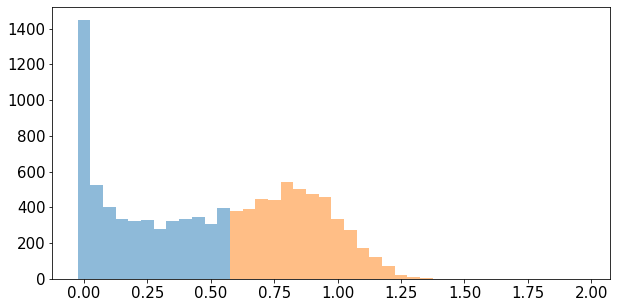

In [51]:
mhist, mbins, mbar = plt.hist(np.array(minus), bins = np.arange(-0.025, alpha_BEST + 0.075, 0.05, ), alpha=0.5)
phist, pbins, pbar = plt.hist(np.array(plus), bins = np.arange(alpha_BEST - 0.025, 2.025, 0.05, ), alpha=0.5)
# plt.xlabel('alpha')
# plt.ylabel('number of times')
# plt.show()

In [52]:
mtempcov = 0
j = 1
while mtempcov < 0.68:
    mtempcov = mtempcov + (mhist[-j] / len(minus))
    j += 1
ptempcov = 0
k = 0
while ptempcov < 0.68:
    ptempcov = ptempcov + (phist[k] / len(plus))
    k += 1
deltam = alpha_BEST - np.mean([mbins[-j+1], mbins[-j]])
deltap = np.mean([pbins[k-1], pbins[k]]) - alpha_BEST

print("Deltap =", deltap, ", Deltam =", deltam)

Deltap = 0.3500000000000003 , Deltam = 0.5


In [53]:
print("Therefore the median of the minimums is:", alpha_BEST, "+", np.round(deltap, decimals = 2), "-", np.round(deltam, decimals = 2)) 

Therefore the median of the minimums is: 0.55 + 0.35 - 0.5


This median uncertainty is the minimum uncertainty that contains a 68% or more of the upper or lower minimums.

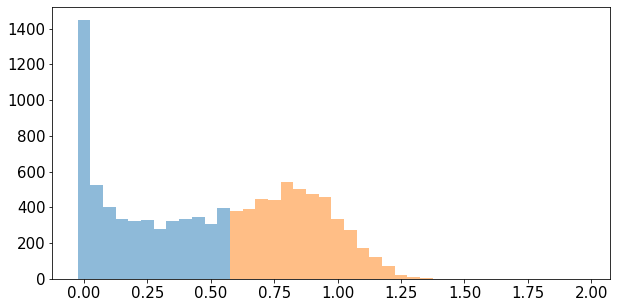

In [54]:
plt.hist(np.array(minus), bins = np.arange(-0.025, alpha_BEST + 0.075, 0.05), alpha = 0.5)
plt.hist(np.array(plus), bins = np.arange(alpha_BEST - 0.075, 2.025, 0.05), alpha=0.5)
plt.show()

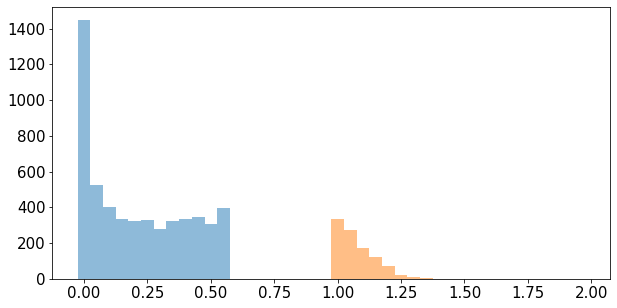

In [55]:
plt.hist(np.array(minus), bins = np.arange(-0.025, 1.075, 0.05), alpha = 0.5)
plt.hist(np.array(plus), bins = np.arange(0.975, 2.025, 0.05), alpha=0.5)
plt.show()

In [26]:
locname = '/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_PWL_MAGIC_with_0.0_Systematics_4w_fix_2errors_x10'
loc = Path(locname)

with open(locname + "/EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)
        
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

niter = len(chisqs_iter)

alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]

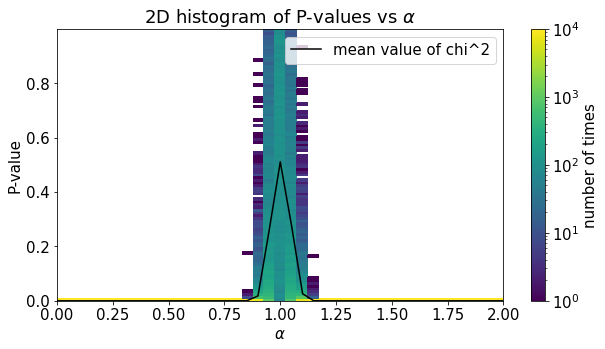

In [27]:
npoints = 19 #should be 19
nfreeparams = 2 #PWL 2, LP 3, MBPWL 2 + n breaks (not completely true for MBPWL + 1 for alpha as free parameter
ndof = npoints - nfreeparams        
        
pval_iter = chi2.sf(chisqs_iter, ndof)
pval_iter2 = chi2.sf(chisqs_iter2, ndof)
fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(pval_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
h = ax.hist2d(alphas_iter2, pval_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), label="histogram of chi^2 values")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'P-value')
ax.legend()
ax.set_ylim(bottom = 0)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of P-values vs $\alpha$")
plt.show()

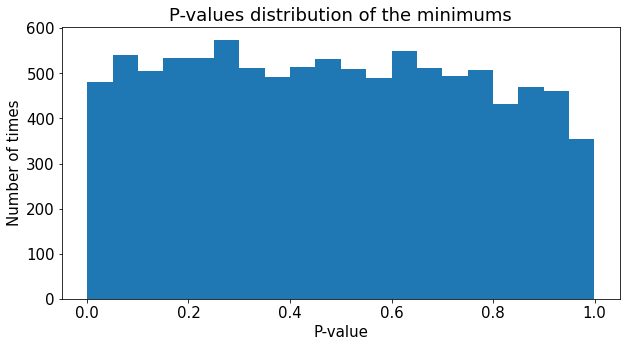

In [30]:
#p-values of the minimums now 16 dof
minimums = []
chis_min = []

for i in range(len(chisqs_iter)):
    order = np.argsort(alphas_iter[0])
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(alphas_iter[i], order, axis=0)
    chisqs_reord = np.take_along_axis(chisqs_iter[i], order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
    chis_new = f1(interpx)
    minimums.append(np.round(interpx[np.argmin(chis_new)], decimals = 3))
    chis_min.append(np.min(chis_new))

npoints = 19 #should be 19
nfreeparams = 2+1 #PWL 2, LP 3, MBPWL 2 + n breaks (not completely true for MBPWL + 1 for alpha as free parameter
ndof = npoints - nfreeparams

pval_mins = 1-chi2.cdf(chis_min, ndof)
plt.hist(pval_mins, bins = 20)
plt.title("P-values distribution of the minimums")
plt.xlabel("P-value")
plt.ylabel("Number of times")
plt.show()

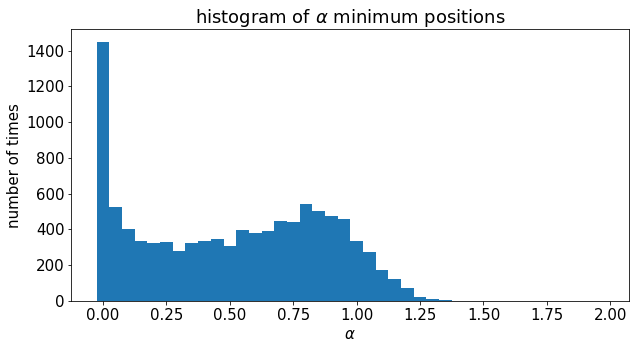

The mean is: 0.5057 ± 0.0036


In [58]:
mu, std = norm.fit(alphas[np.argmin(chisqs_iter, axis = 1)])

plt.hist(alphas[np.argmin(chisqs_iter, axis = 1)], np.sort(alphas)-0.025)
xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
p = norm.pdf(np.sort(alphas), mu, std)
#plt.axvline(np.median(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "median value", color = "red")
#plt.axvline(np.mean(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "mean value", color = "orange",)
#plt.plot(np.sort(alphas), p/p.sum() * niter, 'k', linewidth=2)
plt.xlabel(r'$\alpha$')
plt.ylabel("number of times")
plt.title(r"histogram of $\alpha$ minimum positions")
#plt.legend(fontsize = 15)
plt.show()
print("The mean is:", format(mu, ".4f"), u"\u00B1", format(std/np.sqrt(niter), ".4f"))
# print("Energy migration =", Energy_migration)

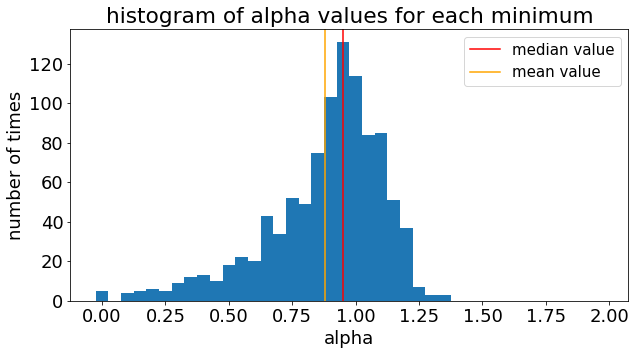

The mean is: 0.8796 ± 0.0537


In [126]:
loc = Path('/data/magic/users-ifae/rgrau/EBL-splines/EBL1000_PWL_LP_MAGIC_with_0.05_Systematics_4w_fix_2_test')

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)


# dffinal = pd.concat([extract(name) for name in files] )

# chisqs_iter = np.array(dffinal['chisqs'])
# alphas_iter = np.array(dffinal['alphas'])

with open("EBL_fit_config.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
    knots = inp_config["knots"]
    Efirst = inp_config["Efirst"]
    Elast = inp_config["Elast"]
    
mu, std = norm.fit(alphas[np.argmin(chisqs_iter, axis = 1)])

plt.hist(alphas[np.argmin(chisqs_iter, axis = 1)], np.sort(alphas)-0.025)
xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
p = norm.pdf(np.sort(alphas), mu, std)
plt.axvline(np.median(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "median value", color = "red")
plt.axvline(np.mean(alphas[np.argmin(chisqs_iter, axis = 1)]), label = "mean value", color = "orange",)
#plt.plot(np.sort(alphas), p/p.sum() * niter, 'k', linewidth=2)
plt.xlabel("alpha")
plt.ylabel("number of times")
plt.title("histogram of alpha values for each minimum")
plt.legend(fontsize = 15)
plt.show()
print("The mean is:", format(mu, ".4f"), u"\u00B1", format(std/np.sqrt(niter), ".4f"))

In [127]:
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

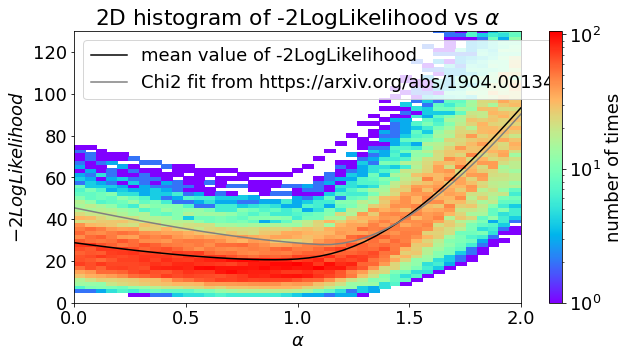

A 59.5 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 88.8 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 98.0 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The mean minimum is at alpha =  0.9  +  0.15  -  0.26
0 of 1000 itertions failed to converge
Δχ^2 min-0 = 8.164710826057227
Δχ^2 min-2 = 72.57027290131674


In [79]:
niter = len(chisqs_iter)

alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of -2LogLikelihood")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label=r"histogram of $\chi^2$ values")
ax.plot(magicalphas, magichis, color = "grey", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend(loc='upper left')
ax.set_ylim(bottom = 0)
#ax.set_xlim(0.5,1.5)
ax.set_ylim(0,130)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of -2LogLikelihood vs $\alpha$")
plt.show()

sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    number = np.where(np.round(alphas, decimals = 4) == 1)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / (niter) * 100, decimals = 3)))
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.mean(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.mean(chisqs_iter, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
print("The mean minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 2), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
# print("Energy migration = ", Energy_migration)
print("{failed} of {total} itertions failed to converge".format(failed = len(files) - niter, total = len(files)))
print("\u0394" + "\u03C7" + r"^2" + " min-0 = {0}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[0] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))
print("\u0394" + "\u03C7" + r"^2" + " min-2 = {0}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[-1] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))

Wilk's coverages:

In [12]:
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas

loc = Path('/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_PWL_MAGIC_with_0.0_Systematics_4w_fix_2errors_x10')
# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)


# dffinal = pd.concat([extract(name) for name in files] )

# chisqs_iter = np.array(dffinal['chisqs'])
# alphas_iter = np.array(dffinal['alphas'])

with open("EBL_fit_config.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        Elast = inp_config["Elast"]

A 85.79 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 96.19 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 99.82 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The mean minimum is at alpha =  1.0  +  0.0  -  0.0
0 of 10000 itertions failed to converge


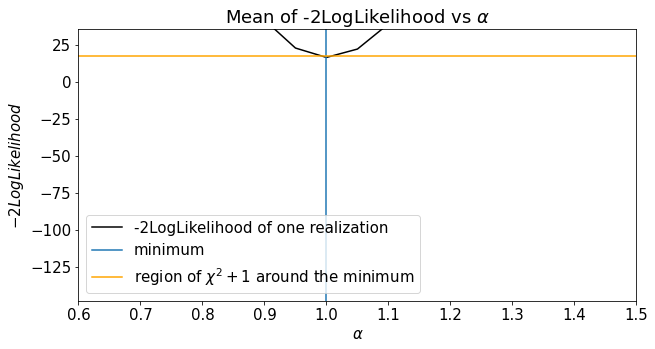

In [13]:
niter = len(chisqs_iter)

alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="-2LogLikelihood of one realization")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.set_ylim(top = 36)
ax.set_xlim(0.6,1.5)
ax.set_title(r"Mean of -2LogLikelihood vs $\alpha$")


sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
number = np.where(np.round(alphas, decimals = 4) == 1)
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / (niter) * 100, decimals = 3)))
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.mean(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.mean(chisqs_iter, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
print("The mean minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 3), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
# print("Energy migration = ", Energy_migration)
print("{failed} of {total} itertions failed to converge".format(failed = len(files) - niter, total = len(files)))

ax.axvline(x =  np.round(interpx[np.argmin(chis_new)], decimals = 3), label = "minimum")
plt.axhline(y = 1 + np.min(chis_new), color = 'orange', label = r"region of $\chi^2+1$ around the minimum")
ax.legend()
plt.show()

68% coverage

In [14]:
order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.mean(alphas_iter, 0), order, axis=0)
chisqs_reord = np.take_along_axis(np.mean(chisqs_iter, 0), order, axis=0)
alphas_best = []
for i in range(len(alphas_iter)):
    alphas_best.append(alphas_iter[i][np.argmin(chisqs_iter[i])])
alphas_best = np.round(alphas_best, decimals = 2)
alpha_BEST = np.round(interpx[np.argmin(chis_new)], decimals = 2)
minus = []
plus = []
for i in range(len(alphas_iter)):
    if np.round(alphas_iter[i][np.argmin(chisqs_iter[i])], decimals = 2) <= alpha_BEST:
        minus.append(np.round(alphas_iter[i][np.argmin(chisqs_iter[i])], decimals = 2))
    if np.round(alphas_iter[i][np.argmin(chisqs_iter[i])], decimals = 2) >= alpha_BEST:
        plus.append(np.round(alphas_iter[i][np.argmin(chisqs_iter[i])], decimals = 2))

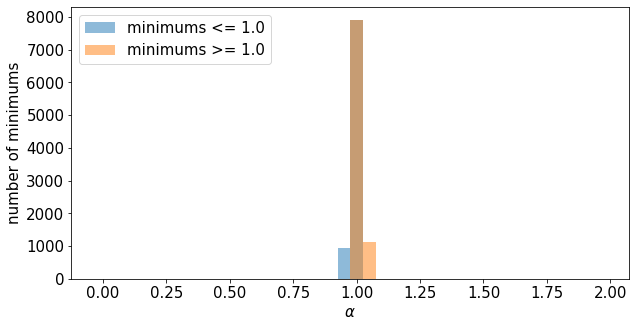

In [15]:
mhist, mbins, mbar = plt.hist(np.array(minus), bins = np.arange(-0.025, alpha_BEST + 0.075, 0.05, ), alpha=0.5, label="minimums <= {minm}".format( minm = alpha_BEST))
phist, pbins, pbar = plt.hist(np.array(plus), bins = np.arange(alpha_BEST - 0.025, 2.025, 0.05, ), alpha=0.5, label="minimums >= {minm}".format(minm = alpha_BEST))
plt.xlabel(r"$\alpha$")
plt.ylabel("number of minimums")
plt.legend(loc="upper left")
plt.show()

In [12]:
mtempcov = 0
j = 1
while mtempcov < 0.68:
    mtempcov = mtempcov + (mhist[-j] / len(minus))
    j += 1
ptempcov = 0
k = 0
while ptempcov < 0.68:
    ptempcov = ptempcov + (phist[k] / len(plus))
    k += 1
deltam = alpha_BEST - np.mean([mbins[-j+1], mbins[-j]])
deltap = np.mean([pbins[k-1], pbins[k]]) - alpha_BEST

print("Deltap =", deltap, ", Deltam =", deltam)

Deltap = 0.20000000000000007 , Deltam = 0.25


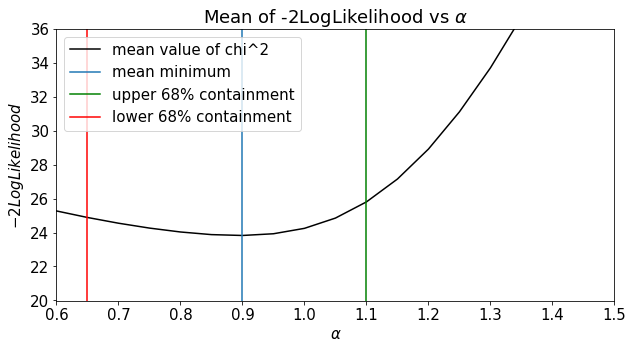

In [13]:
fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.set_ylim(top = 36)
ax.set_xlim(0.6,1.5)
ax.set_title(r"Mean of -2LogLikelihood vs $\alpha$")
ax.axvline(x =  np.round(interpx[np.argmin(chis_new)], decimals = 3), label = "mean minimum")
ax.axvline(x =  np.round(interpx[np.argmin(chis_new)] + deltap, decimals = 3), label = "upper 68% containment", color= 'green')
ax.axvline(x =  np.round(interpx[np.argmin(chis_new)] - deltam, decimals = 3), label = "lower 68% containment", color = 'red')
ax.legend(loc='upper left')
plt.show()


Let's make the 2D histogram of $\Delta+$ and $\Delta-$ vs minimum and then plot the likelihood histogram depending on the selected region of this plot

In [2]:
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas

loc = Path('/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors')
# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []
file_names = []

with open("EBL_fit_config.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)
        file_names.append(name)
minimums = []
deltaps = []
deltams = []

for i in range(len(chisqs_iter)):
    order = np.argsort(alphas_iter[0])
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(alphas_iter[i], order, axis=0)
    chisqs_reord = np.take_along_axis(chisqs_iter[i], order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
    lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
    minimums.append(np.round(interpx[np.argmin(chis_new)], decimals = 3))
    deltaps.append(np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4))
    deltams.append(np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
    

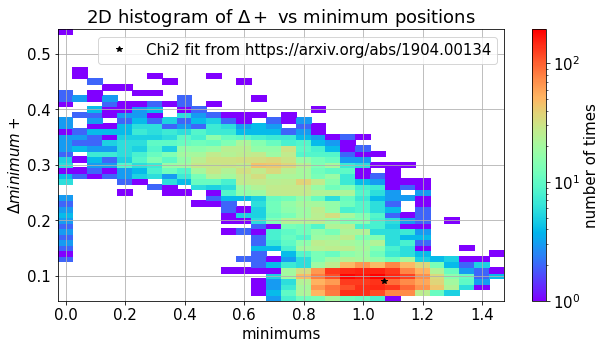

In [3]:
binwmin = 0.05
binwdelta = 0.01
fig, ax = plt.subplots()
binsmins = binwmin/2+np.round(np.arange(np.min(minimums)-binwmin, np.max(minimums)+binwmin, binwmin), decimals = 2)
binsdeltaps = binwdelta/2+np.round(np.arange(np.min(deltaps)-binwdelta, np.max(deltaps)+binwdelta, binwdelta), decimals = 2)
h = ax.hist2d(minimums, deltaps, bins=[binsmins, binsdeltaps], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of minimums and delta+") #[int(np.round((np.min(minimums)+np.max(minimums))/step)), int(np.round((np.min(deltaps)+np.max(deltaps))/0.01))]
ax.set_xlabel('minimums')
plt.plot(1.07, 0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
ax.set_ylabel(r'$\Delta minimum +$')
ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\Delta +$ vs minimum positions")
ax.grid(which='both', axis='both')
plt.show()

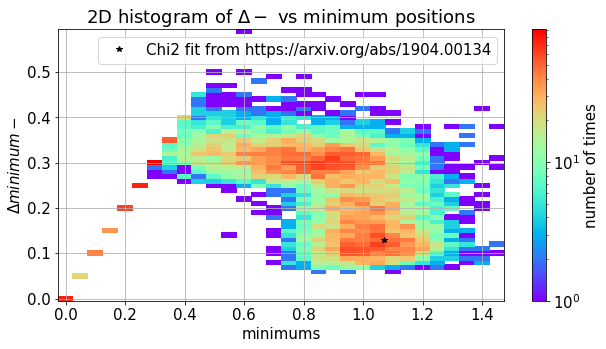

In [4]:
fig, ax = plt.subplots()
binsdeltams = binwdelta/2+np.round(np.arange(np.min(deltams)-binwdelta, np.max(deltams)+binwdelta, binwdelta), decimals = 2)
h = ax.hist2d(minimums, deltams, bins=[binsmins,binsdeltams], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of minimums and delta-")
ax.set_xlabel('minimums')
ax.set_ylabel(r'$\Delta minimum -$')
plt.plot(1.07, 0.13, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\Delta -$ vs minimum positions")
ax.grid(which='both', axis='both')
plt.show()

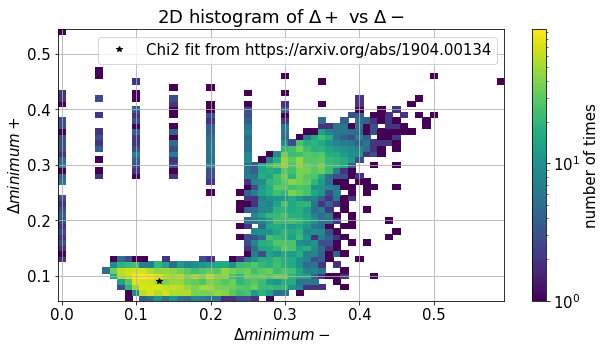

In [5]:
fig, ax = plt.subplots()
h = ax.hist2d(deltams, deltaps, bins=[binsdeltams, binsdeltaps], norm = colors.LogNorm(), label="histogram of minimums and delta+") #[int(np.round((np.min(minimums)+np.max(minimums))/step)), int(np.round((np.min(deltaps)+np.max(deltaps))/0.01))]
ax.set_xlabel('$\Delta minimum -$')
plt.plot(0.13, 0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
ax.set_ylabel(r'$\Delta minimum +$')
ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\Delta +$ vs $\Delta -$")
ax.grid(which='both', axis='both')
plt.show()

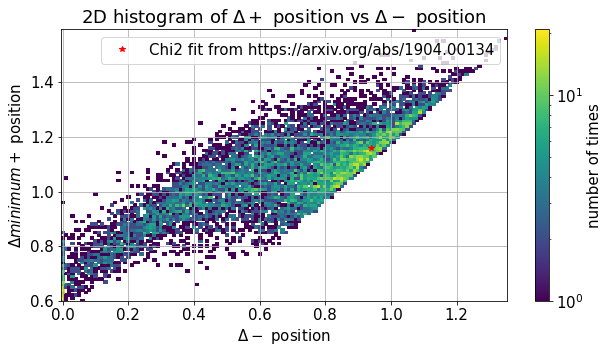

In [6]:
fig, ax = plt.subplots()
binw = 0.01
binsdeltamsmin = binw/2+np.round(np.arange(np.min(np.array(minimums) - np.array(deltams))-binw, np.max(np.array(minimums) - np.array(deltams))+binw, binw), decimals = 2)
binsdeltapsmin = binw/2+np.round(np.arange(np.min(np.array(minimums) + np.array(deltaps))-binw, np.max(np.array(minimums) + np.array(deltaps))+binw, binw), decimals = 2)
h = ax.hist2d(np.array(minimums) - np.array(deltams), np.array(minimums) + np.array(deltaps), bins=[binsdeltamsmin, binsdeltapsmin], norm = colors.LogNorm(), label="histogram of minimums and delta+") #[int(np.round((np.min(minimums)+np.max(minimums))/step)), int(np.round((np.min(deltaps)+np.max(deltaps))/0.01))]
ax.set_xlabel('$\Delta -$ position')
plt.plot(1.07-0.13, 1.07+0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'red')
ax.set_ylabel(r'$\Delta minimum +$ position')
#ax.axvline(x =  1.07-0.13)
#ax.axhline(y =  1.07+0.09)
ax.legend()
ax.set_ylim(bottom = 0.6)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\Delta +$ position vs $\Delta -$ position")
ax.grid(which='both', axis='both')
plt.show()

We will check the realizations in every zone

In [33]:
maxmin = 1.25
minmin = 1.05
maxdeltap = 0.7
mindeltap = 0.00
maxdeltam = 0.15#0.2
mindeltam = 0.1#0.05

if maxmin < minmin or maxdeltap < mindeltap or maxdeltam < mindeltam:
    print(" Warning, one max is smaller than one min")

In [34]:
newminimums = []
newdeltaps = []
newdeltams = []
newchisqs = []
newalphas = []
newindexes = []

for i in range(len(chisqs_iter)):
    if minimums[i] >= minmin and minimums[i] <= maxmin: #conditions in the minimums
        if deltaps[i] <= maxdeltap and deltaps[i] >= mindeltap: #conditions in the deltap
            if deltams[i] <= maxdeltam and deltams[i] >= mindeltam:
                newminimums.append(minimums[i])
                newdeltaps.append(deltaps[i])
                newdeltams.append(deltams[i])
                newchisqs.append(chisqs_iter[i])
                newalphas.append(alphas_iter[i])
                newindexes.append(i)
        
niter = len(chisqs_iter)

newalphas2 = np.concatenate(newalphas)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
newchisqs2 = np.concatenate(newchisqs)
neworder = np.argsort(newalphas[0])
newalphas_noiter = newalphas[0]

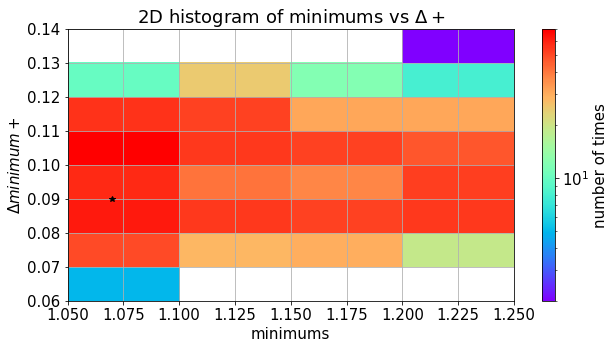

In [35]:
fig, ax = plt.subplots()
newbinsmins = np.round(np.arange(np.min(newminimums), np.max(newminimums)+0.05, 0.05), decimals = 2)
newbinsdeltaps = np.round(np.arange(np.min(newdeltaps), np.max(newdeltaps)+0.01, 0.01), decimals = 2)
h = ax.hist2d(newminimums, newdeltaps, bins=[newbinsmins, newbinsdeltaps], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of minimums and delta+") #[int(np.round((np.min(minimums)+np.max(minimums))/step)), int(np.round((np.min(deltaps)+np.max(deltaps))/0.01))]
ax.set_xlabel('minimums')
plt.plot(1.07, 0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
# plt.plot(1.07, 0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
ax.set_ylabel(r'$\Delta minimum +$')
# ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of minimums vs $\Delta +$")
ax.grid(which='both', axis='both')
plt.show()

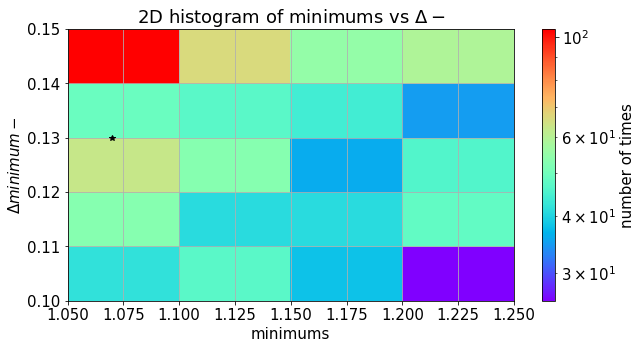

In [36]:
fig, ax = plt.subplots()
newbinsmins = np.round(np.arange(np.min(newminimums), np.max(newminimums)+0.05, 0.05), decimals = 2)
newbinsdeltams = np.round(np.arange(np.min(newdeltams), np.max(newdeltams)+0.01, 0.01), decimals = 2)
h = ax.hist2d(newminimums, newdeltams, bins=[newbinsmins, newbinsdeltams], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of minimums and delta+") #[int(np.round((np.min(minimums)+np.max(minimums))/step)), int(np.round((np.min(deltaps)+np.max(deltaps))/0.01))]
ax.set_xlabel('minimums')
# plt.plot(1.07, 0.09, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
ax.set_ylabel(r'$\Delta minimum -$')
plt.plot(1.07, 0.13, '*', label= "Chi2 fit from https://arxiv.org/abs/1904.00134", color = 'black')
# ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of minimums vs $\Delta -$")
ax.grid(which='both', axis='both')
plt.show()

In [37]:
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

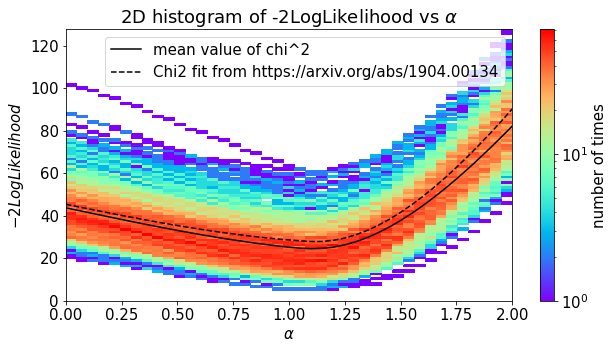

A 59.819 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 99.799 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 100.0 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The mean minimum is at alpha =  1.1  +  0.11  -  0.12
993 of 10000 itertions are inside this region


In [38]:
fig, ax = plt.subplots()
ax.plot(np.take_along_axis(newalphas[0], neworder, axis=0), np.take_along_axis(np.mean(newchisqs,0), neworder, axis=0), color = "black", label="mean value of chi^2")
h = ax.hist2d(newalphas2, newchisqs2, bins=[len(newalphas[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of chi^2 values")
# ax.plot(magicalphas, magichis, color = "grey", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.plot(magicalphas, magichis, color = "black", label= "Chi2 fit from https://arxiv.org/abs/1904.00134", ls="--")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend()
ax.set_ylim(bottom = 0)
#ax.set_xlim(0.5,1.5)
# ax.set_ylim(0,210)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of -2LogLikelihood vs $\alpha$")
plt.show()

niter = len(newchisqs)
sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(newchisqs)):
    sigma_1_0 = np.where(newchisqs[i] <= 1 + np.min(newchisqs[i]))
    sigma_2_0 = np.where(newchisqs[i] <= 4 + np.min(newchisqs[i]))
    sigma_3_0 = np.where(newchisqs[i] <= 9 + np.min(newchisqs[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    number = np.where(np.round(newalphas[0], decimals = 2) == 1)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / (niter) * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / (niter) * 100, decimals = 3)))
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(newalphas[0], order, axis=0)
chisqs_reord = np.take_along_axis(np.mean(newchisqs, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
print("The mean minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 3), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
# print("Energy migration = ", Energy_migration)
print("{failed} of {total} itertions are inside this region".format(failed = niter, total = len(files)))

In [39]:
print(newindexes)

[8, 18, 19, 21, 26, 27, 50, 61, 66, 68, 78, 82, 89, 92, 100, 107, 135, 136, 140, 166, 197, 199, 207, 226, 238, 240, 249, 258, 289, 313, 322, 328, 332, 348, 355, 356, 368, 372, 375, 388, 396, 404, 418, 421, 424, 438, 447, 456, 474, 477, 479, 490, 508, 540, 549, 554, 556, 557, 566, 580, 619, 620, 627, 630, 636, 640, 650, 676, 688, 692, 695, 697, 709, 713, 728, 755, 794, 800, 805, 814, 847, 848, 858, 864, 866, 878, 882, 891, 895, 896, 903, 910, 940, 945, 959, 963, 983, 998, 1005, 1013, 1017, 1031, 1039, 1044, 1046, 1049, 1055, 1089, 1094, 1100, 1101, 1115, 1119, 1131, 1134, 1137, 1162, 1176, 1180, 1181, 1189, 1208, 1210, 1236, 1237, 1239, 1242, 1263, 1266, 1272, 1284, 1293, 1310, 1330, 1331, 1345, 1361, 1364, 1367, 1373, 1374, 1379, 1415, 1423, 1425, 1429, 1433, 1443, 1444, 1453, 1463, 1472, 1492, 1498, 1499, 1500, 1525, 1542, 1556, 1559, 1566, 1567, 1596, 1616, 1623, 1624, 1625, 1630, 1655, 1661, 1671, 1688, 1691, 1692, 1711, 1723, 1724, 1733, 1737, 1751, 1752, 1753, 1762, 1769, 1770, 17

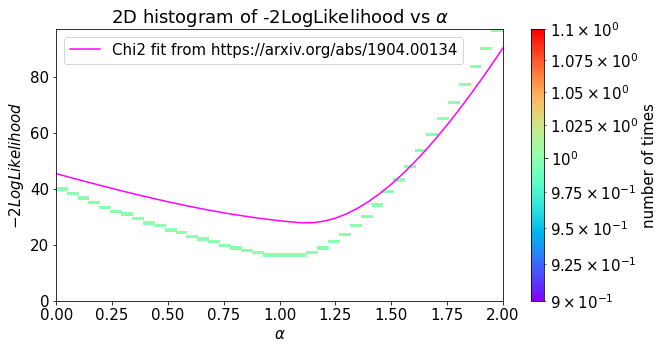

993 of 10000 itertions are inside this region


In [40]:
#use this to find weird realizations
newindexes2 = newindexes[1]
if isinstance(newindexes2, int):
    newalphas3 = np.array(alphas_iter)[newindexes2] 
    newchisqs3 = np.array(chisqs_iter)[newindexes2] 
else:   
    newalphas3 = np.concatenate(np.array(alphas_iter)[newindexes2])
    newchisqs3 = np.concatenate(np.array(chisqs_iter)[newindexes2])

   

fig, ax = plt.subplots()
h = ax.hist2d(newalphas3, newchisqs3, bins=[len(newalphas[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of chi^2 values")
# ax.plot(magicalphas, magichis, color = "grey", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.plot(magicalphas, magichis, color = "fuchsia", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend()
ax.set_ylim(bottom = 0)
#ax.set_xlim(0.5,1.5)
# ax.set_ylim(0,210)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of -2LogLikelihood vs $\alpha$")
plt.show()

niter = len(np.array(chisqs_iter)[newindexes])

print("{failed} of {total} itertions are inside this region".format(failed = niter, total = len(files)))

Formula:
$1.e-6*(x*(x*exp([0]+(([1]-([2]*([2]*log10(x/249.00))))*log(x/249.00)))))$
GetParameter(0) ($\Gamma$)
-2.08634426605417183e+01
GetParameter(1)
-2.07079579682308257e+00
GetParameter(2)
3.72336583721839309e-01

In [41]:
for i in range(len(newindexes)):
    print(file_names[newindexes[i]])

/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1007of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1016of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1017of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1019of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1023of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1024of1000_202302071520.hdf5
/data/magic/users-ifae/rgrau/EBL-splines/EBL10000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2errors/EBL_mult_nit1045of1000_202302071522.hdf5
/data/magic/u

In [ ]:
fileop = h5py.File(file_names[newindexes[1]], "r")
if 'chisqs' in fileop:
    chisqs, alphas = extract(fileop)
plt.plot(alphas, chisqs)

In [ ]:
for i in newindexes:
    print(file_names[i])